In [1]:
## time features
import torch 
import neuralprophet
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed 
set_log_level("ERROR", "INFO")

import numpy as np
set_random_seed(0)
import pandas as pd
from sklearn.preprocessing import StandardScaler

import copy 
from typing import List

import numpy as np
import pandas as pd 
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5



def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)



def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])


In [59]:
import os
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
#from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=False, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        print ("default size is: ", size)
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        print ("border1, border2, self.features, self.scale, self.timeenc: ", 
        border1, border2, self.features, self.scale, self.timeenc)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        
        print ("self.timeenc: ", self.timeenc)
        
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
        print (len(self.data_x), type(self.data_x), self.data_x.shape)

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        #print ("inside getitem: ",s_begin, s_end, r_begin, r_end)
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [60]:
#from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from torch.utils.data import DataLoader

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
}


def data_provider(args, flag):
    print ("arguments: ", args)
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1
    train_only = args.train_only

    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        Data = Dataset_Pred
    else:
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        train_only=train_only
    )
    print("---------this is in data_factory :", flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        #num_workers=1#args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Model(nn.Module):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        print ("self.seq_len, self.pred_len: ",self.seq_len, self.pred_len )
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        print ("individual flag: ",self.individual) 
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len) # 336, 96

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            #print ("x shape in forward: ", x.size())
            #print ("x shape after Linear: ", self.Linear(x.permute(0,2,1)).size() )
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

In [62]:

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss



In [63]:
class arguments():
    def __init__(self):
            self.model_id = "ETTh1_336_len_96"
            self.model = "Linear"
            self.data = "ETTh1"
            self.features = "M"
            self.seq_len = 336
            self.label_len =48 ## check this one  
            self.pred_len = 96
            self.d_model = "512"
            self.n_heads ="n_heads"
            self.e_layers ="2" 
            self.d_layers = "1"
            self.d_ff = "2048"
            self.factor ="1" 
            self.embed = "timeF"
            self.distil = ""
            self.des = "Exp"
            self.train_only = False
            self.batch_size = 32
            self.freq = "h"
            self.root_path = "dataset/"
            self.data_path = "ETTh1.csv"
            self.target = "OT"
            self.num_workers = 4
            self.enc_in=1
            self.individual=False

In [64]:
args_ = arguments()
train_data, train_loader=data_provider(args_, flag='train')

arguments:  <__main__.arguments object at 0x7fec9119cb50>
default size is:  [336, 48, 96]
border1, border2, self.features, self.scale, self.timeenc:  0 8640 M False 1
self.timeenc:  1
8640 <class 'numpy.ndarray'> (8640, 7)
---------this is in data_factory : train 8209


In [65]:
# train_data.__getitem__(0)[3].shape

In [70]:
import torch.optim as optim

train_steps = len(train_loader)
early_stopping = EarlyStopping(patience=3, verbose=True)

model=Model(args_)
model_optim = optim.Adam(model.parameters() , lr=0.01)
criterion = nn.MSELoss()

self.seq_len, self.pred_len:  336 96
individual flag:  False


In [67]:
train_loader

In [134]:
for epoch in range(1):
    print ("epoch", epoch)
    iter_count = 0
    train_loss = []

    model.train() ## this sets the flag model.training = True in pytorch nn.Module train function. 
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        if iter_count==len(train_loader)-1:
            print ("-------------iter_count--------: ",iter_count)
            x_store = batch_x
            y_store = batch_y
        iter_count += 1
        model_optim.zero_grad()
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = model(batch_x)
        
        #print ("calculated outputs:",i, outputs.shape, batch_x.shape, batch_y.shape)
        f_dim = -1 if args_.features == 'MS' else 0
        outputs = outputs[:, -args_.pred_len:, f_dim:]
        batch_y = batch_y[:, -args_.pred_len:, f_dim:]
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()

epoch 0
-------------iter_count--------:  255


### The last row in last batch will be 32x256 + 336 + 1 = 8528 

In [135]:
len(train_loader)

256

In [136]:
list(model.parameters())[0].shape

torch.Size([96, 336])

<AxesSubplot:>

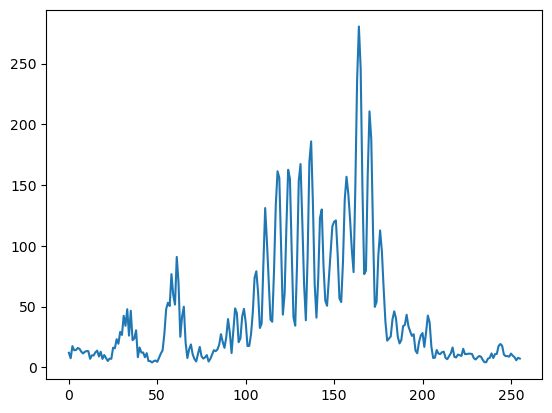

In [137]:
pd.Series(train_loss).plot()

In [147]:
x_store[31][335]

tensor([ 9.0420,  1.3400,  6.7520,  1.3860,  2.9850, -0.5480, 18.2200],
       dtype=torch.float64)

In [133]:
x_store[0][0]

tensor([ 5.8270,  2.0090,  1.5990,  0.4620,  4.2030,  1.3400, 30.5310],
       dtype=torch.float64)

In [127]:
len(y_store)

32

In [38]:
outputs[0].shape

torch.Size([96, 7])

In [148]:
256*32 + 336

8528

In [42]:
8640

8208

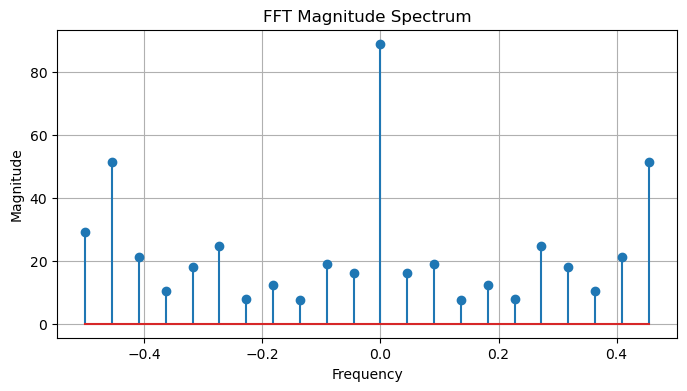

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Input data
data = np.array([1, 2, 0, 3, -1, 10, -2, 12, -3, 14,5,4,3,5,4,-3, 14,5,4,3,5,4])

# Compute FFT
fft_result = np.fft.fft(data)

# Get frequency axis
n = data.shape[0]
freq = np.fft.fftfreq(n)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.stem(freq, np.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT Magnitude Spectrum')
plt.grid(True)
plt.show()


<AxesSubplot:>

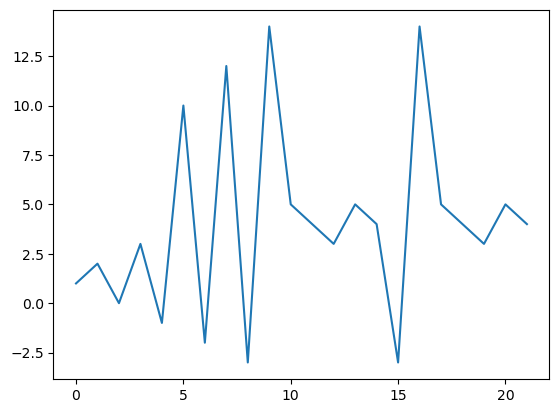

In [163]:
pd.Series(data).plot()

In [164]:
data.shape

(22,)

In [165]:
fft_result

array([ 89.        +0.00000000e+00j, -15.4877773 +4.91939966e+00j,
        -8.01333319+1.71672689e+01j,  -2.01286859-7.36342643e+00j,
         9.38876908+7.74817825e+00j,   4.98825789+6.22529930e+00j,
       -24.69853143+1.32452923e+00j,  10.1264736 -1.47943930e+01j,
        -1.992542  +1.01179354e+01j,   0.3859144 +2.12238319e+01j,
         8.31563754-5.07111784e+01j, -29.        +1.77635684e-15j,
         8.31563754+5.07111784e+01j,   0.3859144 -2.12238319e+01j,
        -1.992542  -1.01179354e+01j,  10.1264736 +1.47943930e+01j,
       -24.69853143-1.32452923e+00j,   4.98825789-6.22529930e+00j,
         9.38876908-7.74817825e+00j,  -2.01286859+7.36342643e+00j,
        -8.01333319-1.71672689e+01j, -15.4877773 -4.91939966e+00j])

In [166]:
freq

array([ 0.        ,  0.04545455,  0.09090909,  0.13636364,  0.18181818,
        0.22727273,  0.27272727,  0.31818182,  0.36363636,  0.40909091,
        0.45454545, -0.5       , -0.45454545, -0.40909091, -0.36363636,
       -0.31818182, -0.27272727, -0.22727273, -0.18181818, -0.13636364,
       -0.09090909, -0.04545455])